<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Action-Recognition/blob/main/Human_Action_Recognition_using_Sensor_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
gdrive_path = "drive/My Drive/Dataset/all_data.csv"

Mounted at /content/drive


In [ ]:
!pip install minepy
# !pip install info_gain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from minepy import MINE
from sklearn.feature_selection import mutual_info_regression
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from scipy.special import entr
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import differential_entropy
from scipy.stats import entropy

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 496 kB 5.3 MB/s 
  Created wheel for minepy: filename=minepy-1.2.6-cp37-cp37m-linux_x86_64.whl size=177584 sha256=480df9d52e0416f322b4556bba7a454eed8b14242d53f84938ba51e0bfc0ab55
  Stored in directory: /root/.cache/pip/wheels/81/71/75/403a33428e468a25c93fa7b672d070b304f36642eb699a29e0
Successfully built minepy


In [ ]:
df = pd.read_csv(gdrive_path)
df.tail()

,Unnamed: 0,0_mean_x,0_var_x,0_kurt_x,0_max_x,0_min_x,0_dc_comp_x,0_spec_energy_x,0_spec_entropy_x,0_max_psd_x,...,9_dc_comp_m,9_spec_energy_m,9_spec_entropy_m,9_max_psd_m,9_min_psd_m,9_min_max_psd_m,9_max_xas_m,9_min_xas_m,9_min_max_xas_m,activity
1160,1160,-0.054506,0.001862,-0.040152,0.072510,-0.149658,4178.914871,15331.889818,3.857213,0.420883,...,1.338846e+06,1.511391e+09,6.555544,0.113631,3.274603e-09,2.881788e-08,0.337092,0.000057,0.000170,9
1161,1161,-0.026696,0.002853,5.849030,0.427002,-0.189697,842.076824,1492.626785,5.105730,0.373887,...,1.131603e+06,1.178036e+09,6.289649,0.097086,1.527362e-08,1.573198e-07,0.311587,0.000124,0.000397,9
1162,1162,-0.038772,0.001957,37.360906,0.555176,-0.434082,1766.442641,2957.616036,6.873023,0.149166,...,1.123454e+06,1.164343e+09,6.877409,0.068606,6.772243e-08,9.871164e-07,0.261928,0.000260,0.000994,9
1163,1163,-0.084045,0.001579,-0.482562,0.028564,-0.166016,9406.587377,77108.344139,3.375543,0.413470,...,1.274956e+06,1.408591e+09,6.892931,0.061177,1.379768e-08,2.255369e-07,0.247340,0.000117,0.000475,9
1164,1164,-0.043714,0.001209,0.021406,0.071533,-0.119873,1880.480207,3743.618849,3.326524,0.543291,...,9.423824e+05,8.952466e+08,6.628678,0.059656,1.391945e-07,2.333289e-06,0.244246,0.000373,0.001528,9


In [ ]:
df.drop(df.columns[df.isna().any()].tolist(), axis = 1, inplace = True)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
##symmetrical uncertainty
def SU(df, X,Y):
  if(Y=='activity'):
    IG = mutual_info_classif(np.transpose(np.array([df[X]])), df[Y]).item()
    H_Y = entropy(df[Y])
  else:
    IG = mutual_info_regression(np.transpose(np.array([df[X]])), df[Y]).item()
    H_Y = differential_entropy(df[Y])
  H_X = differential_entropy(df[X])
  su = ((2.0*IG)/(H_X+H_Y))
  #print(IG,H_X,H_Y, su)
  return su
  
#Fast Correlation Based Filter
def FCBF(df, features, C):
  thresh = 0.000001
  N = len(features)
  S_list = {}
  for i in range(N):
    val = SU(df, features[i], C)
    if(val> thresh):
      S_list[features[i]] = val
  S_list = pd.Series(S_list).sort_values(ascending=False)
  no_features = S_list.shape[0]
  a_list = np.ones(no_features)
  for i in range(no_features):
    if(a_list[i]==1):
      Fp = S_list.index[i]
      for j in range(i+1,no_features):
        if(a_list[j]==1):
          Fq = S_list.index[j]
          if(SU(df, Fp,Fq) >= S_list[j]):
            print(f"{j} has been eleminated while in {i}")
            a_list[j]=0
  idx = np.where(a_list==1)[0]
  return S_list.index[idx]

In [ ]:
features = list(df.columns[:-1])
C = 'activity'
selected_features = FCBF(df, features, C)

344 has been eleminated while in 0
362 has been eleminated while in 0
370 has been eleminated while in 0
375 has been eleminated while in 0
380 has been eleminated while in 0
382 has been eleminated while in 1
372 has been eleminated while in 2
377 has been eleminated while in 2
374 has been eleminated while in 3
366 has been eleminated while in 4
368 has been eleminated while in 4
371 has been eleminated while in 4
376 has been eleminated while in 4
381 has been eleminated while in 12
355 has been eleminated while in 17
226 has been eleminated while in 22
234 has been eleminated while in 22
277 has been eleminated while in 22
319 has been eleminated while in 22
320 has been eleminated while in 22
245 has been eleminated while in 24
324 has been eleminated while in 24
267 has been eleminated while in 27
284 has been eleminated while in 27
287 has been eleminated while in 27
288 has been eleminated while in 27
294 has been eleminated while in 27
301 has been eleminated while in 27
317 h

In [ ]:
scaler = MinMaxScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])
X = df[selected_features]
y = df['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

X_train = torch.from_numpy(X_train.to_numpy().astype(np.float32))
X_test = torch.from_numpy(X_test.to_numpy().astype(np.float32))
y_train =  torch.tensor(y_train.values.astype(np.float32))-1
y_test =  torch.tensor(y_test.values.astype(np.float32))-1

In [ ]:
class ANN(nn.Module):
    def __init__(self,input_size,output_size):
        super(ANN,self).__init__()
        self.hidden1 = nn.Linear(input_size,128)
        self.hidden2 = nn.Linear(128,64)
        self.hidden3 = nn.Linear(64,32)
        self.output = nn.Linear(32,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)
    
    def forward(self,x):
        out = self.hidden1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.hidden2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.output(out)
        return out

In [ ]:
input_size = X_train.shape[1]
output_size = torch.unique(y_train).shape[0]
learning_rate = 0.001
num_epochs = 1001
batch_size = 163
no_of_samples = X_train.shape[0]

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='sum')

In [ ]:
def extract_batch(X,y,batch_size,step):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]

In [ ]:
best_lr = None
best_loss = 100000
best_model = None
best_train_loss = None
for lr in [0.0005,0.001,0.003,0.005,0.01]:
  print(f"Learning rate: {lr}:")
  net = ANN(input_size, output_size)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)  
  train_loss = []
  for epoch in range(num_epochs):
    step = 1
    while(batch_size*step<=no_of_samples):
      x,y =  extract_batch(X_train,y_train, batch_size, step)
      # Forward Propagation
      y_predicted = net(x)
      loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
      #loss = cross_entropy(y_predicted,y)
      # Backward propagation and update
      loss.backward()
      optimizer.step()
      # Performing zero grad before new step
      optimizer.zero_grad()
      step = step+1
    train_loss.append(criterion( net(X_train),  torch.tensor(y_train, dtype=torch.long)).item()) 
      #appending the loss to the loss list
    if(epoch%100==0):
      print(f'epoch: {epoch}, loss = {train_loss[-1]}')
  if(train_loss[-1]<=best_loss):
    best_loss = train_loss[-1]
    best_lr = lr
    best_model = net
    best_train_loss = train_loss
print(f"Best_lr:{best_lr}\nBest_loss:{best_loss}")


Learning rate: 0.0005:
epoch: 0, loss = 2116.648681640625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 100, loss = 67.49040222167969
epoch: 200, loss = 29.46388816833496
epoch: 300, loss = 20.94906234741211
epoch: 400, loss = 20.607646942138672
epoch: 500, loss = 9.627558708190918
epoch: 600, loss = 14.452988624572754
epoch: 700, loss = 7.88195276260376
epoch: 800, loss = 10.223644256591797
epoch: 900, loss = 11.098575592041016
epoch: 1000, loss = 7.954860687255859
Learning rate: 0.001:
epoch: 0, loss = 1952.1739501953125
epoch: 100, loss = 34.93665313720703
epoch: 200, loss = 18.651456832885742
epoch: 300, loss = 14.303513526916504
epoch: 400, loss = 8.27188777923584
epoch: 500, loss = 7.292801856994629
epoch: 600, loss = 5.4057536125183105
epoch: 700, loss = 5.34654426574707
epoch: 800, loss = 4.090232849121094
epoch: 900, loss = 7.083451747894287
epoch: 1000, loss = 8.153142929077148
Learning rate: 0.003:
epoch: 0, loss = 1559.026611328125
epoch: 100, loss = 12.341840744018555
epoch: 200, loss = 6.009915351867676
epoch: 300, loss = 7.114253044128418
epoch: 400, loss = 4.256752

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)   
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum()*1.0 / len(correct_pred)
    acc = acc * 100
    return acc

In [ ]:
y_pred = best_model(X_test)
acc = multi_acc(y_pred, y_test)
print(f"Test accuracy is {(acc):.2f}%")

Test accuracy is 97.71%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'No of Epochs')

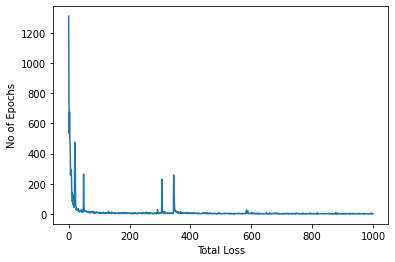

In [ ]:
import seaborn as sns
sns.lineplot(range(1001),best_train_loss)
plt.xlabel("Total Loss")
plt.ylabel("No of Epochs")